# Human Emotions Detection

## Task Understand

Ta cần tạo ra mô hình có thể phát hiện ra rằng, khuôn mặt của người trong ảnh đầu vào biểu thị cho cảm xúc `happy`, `sad` hay `angry`

## Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Resizing, Rescaling, BatchNormalization, Dropout, Flatten, RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix


## Load data

In [2]:
#!pip install -q kaggle

In [3]:
#! kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

In [4]:
train_dir = 'C:/Users/thang/OneDrive/Documents/code/data/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train'
val_dir = 'C:/Users/thang/OneDrive/Documents/code/data/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test'
CLASS_NAMES = ["angry", "happy", "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
}

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=42,
)

Found 6799 files belonging to 3 classes.


In [6]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=42,
)

Found 2278 files belonging to 3 classes.


In [7]:
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 18.       ,  18.       ,  18.       ],
         [ 20.4375   ,  20.4375   ,  20.4375   ],
         [ 23.0625   ,  23.0625   ,  23.0625   ],
         ...,
         [  4.3125   ,   4.3125   ,   4.3125   ],
         [  5.375    ,   5.375    ,   5.375    ],
         [  7.       ,   7.       ,   7.       ]],

        [[ 12.3125   ,  12.3125   ,  12.3125   ],
         [ 13.4296875,  13.4296875,  13.4296875],
         [ 14.6328125,  14.6328125,  14.6328125],
         ...,
         [  4.3125   ,   4.3125   ,   4.3125   ],
         [  5.375    ,   5.375    ,   5.375    ],
         [  7.       ,   7.       ,   7.       ]],

        [[ 13.75     ,  13.75     ,  13.75     ],
         [ 14.003906 ,  14.003906 ,  14.003906 ],
         [ 13.8046875,  13.8046875,  13.8046875],
         ...,
         [  4.3125   ,   4.3125   ,   4.3125   ],
         [  5.5039062,   5.5039062,   5.5039062],
         [  7.6875   ,   7.6875   ,   7.6875

## Data Visualization

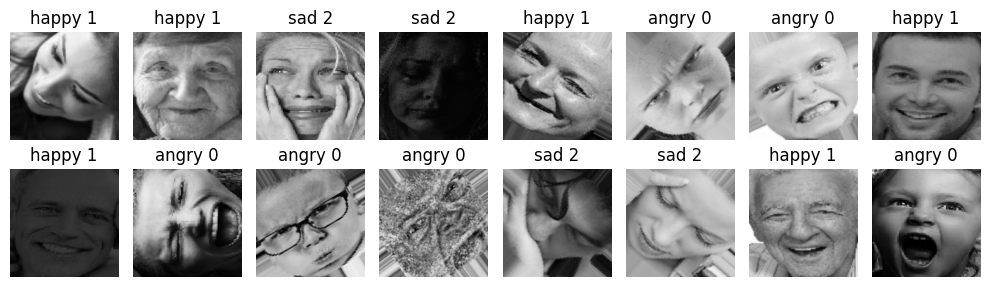

In [8]:
plt.figure(figsize=(10, 3))
for (img, label) in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(2, 8, i + 1)
        plt.imshow(img[i]/255.0)
        plt.title(CLASS_NAMES[tf.argmax(label[i])] + " " + str(tf.argmax(label[i]).numpy()))
        plt.axis('off')
plt.tight_layout()
plt.show()

## Data Augmentation

In [9]:
# sử dụng Keras Layer
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025)), # xoay trong đoạn [-9 độ; 9 độ]
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1),
])

def augment_layer(img, label):
    return augment_layers(img, training=True), label

In [10]:
# CutMix Method

def box(lamda):
  
  r_x = tf.cast(np.random.uniform(0, CONFIGURATION["IM_SIZE"]), dtype = tf.int32)
  r_y = tf.cast(np.random.uniform(0, CONFIGURATION["IM_SIZE"]), dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [11]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = np.random.beta(2, 2)
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## Data Preparation

In [ ]:
# apply cutmix

train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [13]:
training_set = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [14]:
validation_set = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [15]:
# lớp thay đổi kích thước đầu vào và chuẩn hóa hình ảnh
resize_rescale_layer = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
])

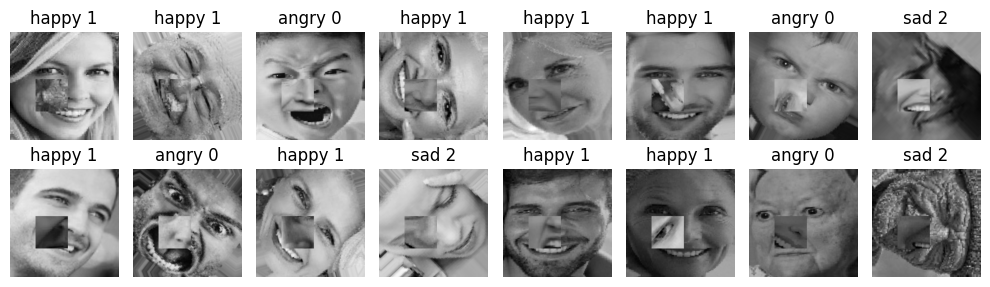

In [16]:
plt.figure(figsize=(10, 3))
for (img, label) in training_set.take(1):
    for i in range(16):
        ax = plt.subplot(2, 8, i + 1)
        plt.imshow(img[i]/255.0)
        plt.title(CLASS_NAMES[tf.argmax(label[i])] + " " + str(tf.argmax(label[i]).numpy()))
        plt.axis('off')
plt.tight_layout()
plt.show()

## Modeling

Bắt đầu thử nghiệm với Lenet Model

In [17]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescale_layer,

    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"],
        activation = "relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2+4, kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"],
        activation = "relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),
    
    Flatten(),

    Dense(CONFIGURATION["N_DENSE_1"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Dense(CONFIGURATION["N_DENSE_2"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    
    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax"),
])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

## Training

In [18]:
loss_function = CategoricalCrossentropy(from_logits=False)

Với hàm kích hoạt của đầu ra là `softmax`, output sẽ là một tensor có 32 giá trị là xác suất hình ảnh thuộc về từng class 0, 1, 2. Thử xem hàm Loss trên sẽ tính toán thế nào với 2 bức ảnh đã được dự đoán

In [19]:
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
cce = CategoricalCrossentropy()
print(cce(y_true, y_pred).numpy())

1.1769392


Công thức của hàm `CategoricalCrossentropy` là

$$
\text{CCE} = - \sum_{i=1}^{M}y_{\text{true}}\log(y_{\text{pred}})
$$

In [20]:
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

- Đối với `CategoricalAccuracy`, với mỗi một cặp y_true và y_pred, nếu index của giá trị lớn nhất của cả 2 bằng nhau thì ta trả về 1, còn lại trả về 0. Ví dụ ta có 3 cặp như sau

$$
\left[ 
    \begin{matrix}
        0.1\\0.4\\0.5
    \end{matrix}
\right]

\left[ 
    \begin{matrix}
        1\\0\\0
    \end{matrix}
\right]
;\ 
\left[ 
    \begin{matrix}
        0.8\\0.1\\0.1
    \end{matrix}
\right]

\left[ 
    \begin{matrix}
        0\\1\\0
    \end{matrix}
\right]

;\ 
\left[ 
    \begin{matrix}
        0.9\\0.05\\0.05
    \end{matrix}
\right]

\left[ 
    \begin{matrix}
        1\\0\\0
    \end{matrix}
\right]
$$

Thì ta có Accuracy là $\displaystyle \frac{0+0+1}{3}=\frac{1}{3}$

- Đối với `TopKCategoricalAccuracy`, với mỗi cặp y_true và y_pred, ta quan tâm top `K` xác suất cao nhất của y_pred và lấy ra index của chúng. Sau đó nếu index của giá trị lớn nhất bên phía y_true phù hợp với bất kỳ index nào đã xác định của y_pred, ta trả về 1, còn lại là 0

Ví dụ tương tự ở trên, ta có TopKAccuracy là $\displaystyle \frac{0+1+1}{3}=\frac{2}{3}$

In [21]:
lenet_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics
)

In [22]:
history = lenet_model.fit(
    training_set,
    validation_data=validation_set,
    epochs=CONFIGURATION["N_EPOCHS"],
    verbose=2
)

Epoch 1/20
213/213 - 59s - loss: 1.0212 - accuracy: 0.5199 - top_k_accuracy: 0.8014 - val_loss: 1.0132 - val_accuracy: 0.5053 - val_top_k_accuracy: 0.7959 - 59s/epoch - 276ms/step
Epoch 2/20
213/213 - 55s - loss: 0.8588 - accuracy: 0.6405 - top_k_accuracy: 0.8688 - val_loss: 0.9240 - val_accuracy: 0.5852 - val_top_k_accuracy: 0.8345 - 55s/epoch - 257ms/step
Epoch 3/20
213/213 - 56s - loss: 0.7974 - accuracy: 0.6776 - top_k_accuracy: 0.8873 - val_loss: 0.8280 - val_accuracy: 0.6260 - val_top_k_accuracy: 0.8709 - 56s/epoch - 261ms/step
Epoch 4/20
213/213 - 55s - loss: 0.7257 - accuracy: 0.7286 - top_k_accuracy: 0.9125 - val_loss: 0.8842 - val_accuracy: 0.6040 - val_top_k_accuracy: 0.8538 - 55s/epoch - 257ms/step
Epoch 5/20
213/213 - 55s - loss: 0.7087 - accuracy: 0.7413 - top_k_accuracy: 0.9209 - val_loss: 1.0103 - val_accuracy: 0.5426 - val_top_k_accuracy: 0.8161 - 55s/epoch - 257ms/step
Epoch 6/20
213/213 - 56s - loss: 0.6551 - accuracy: 0.7756 - top_k_accuracy: 0.9375 - val_loss: 0.82

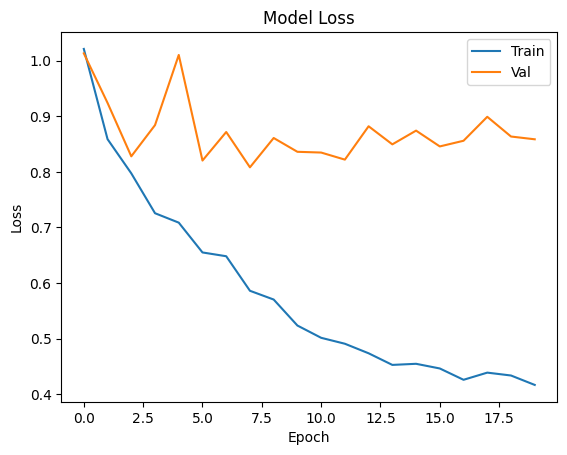

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"])
plt.show()

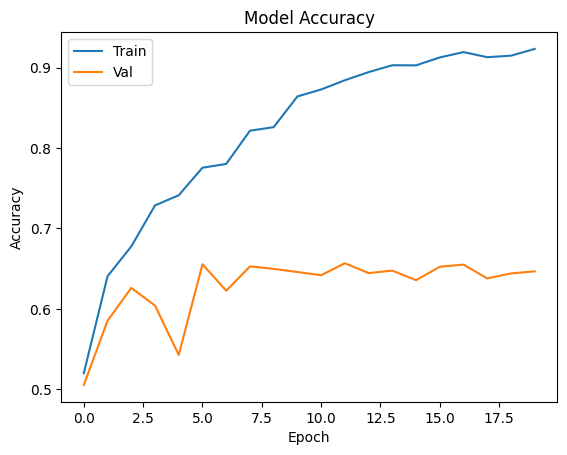

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"])
plt.show()

## Model Evaluation

In [25]:
lenet_model.evaluate(validation_set)

72/72 [==============================] - 2s 30ms/step - loss: 0.8586 - accuracy: 0.6466 - top_k_accuracy: 0.8837


[0.8586286306381226, 0.6466198563575745, 0.883669912815094]

## Testing

In [26]:
def model_test(im):
    im = tf.constant(im, dtype=tf.float32)
    im = tf.expand_dims(im, axis=0)

    int_label = tf.argmax(lenet_model(im), axis = 1)
    string_label = CLASS_NAMES[tf.argmax(lenet_model(im), axis = 1)[0].numpy()]
    return int_label, string_label

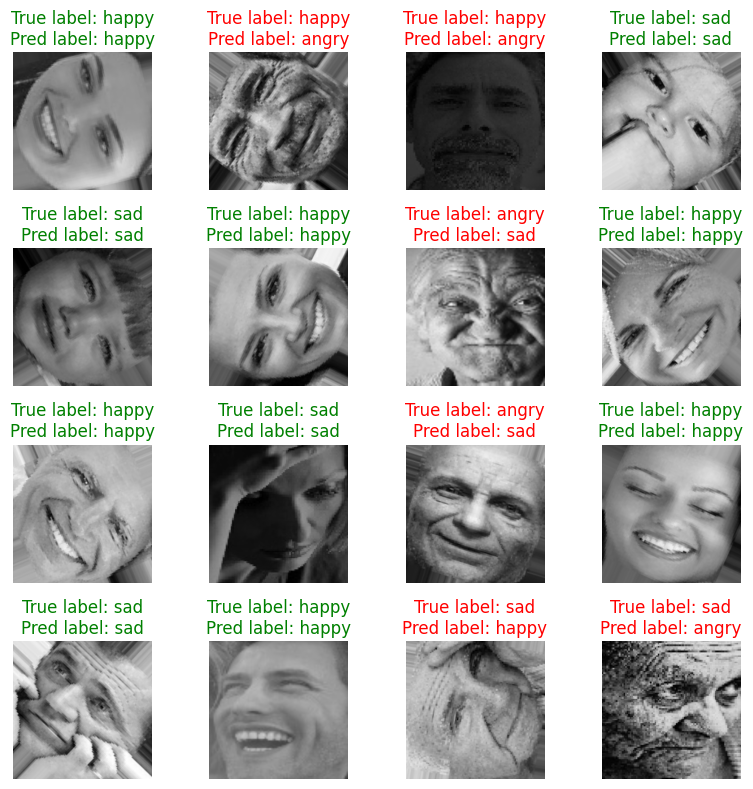

In [27]:
plt.figure(figsize=(8, 8))

for images, labels in validation_set.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.0)
        pred_label = model_test(images[i])[-1]
        if CLASS_NAMES[tf.argmax(labels[i])]==pred_label:
            color = 'green'
        else:
            color = 'red'
        plt.axis('off')
        plt.title(f"True label: {CLASS_NAMES[tf.argmax(labels[i])]}\nPred label: {pred_label}", color = color)
plt.tight_layout()
plt.show()

## Confusion Matrx

In [28]:
predicted = []
labels = []

for im, label in validation_set:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())

In [29]:
lab = np.concatenate([np.argmax(each_label, axis = 1) for each_label in labels])
pred = np.concatenate([np.argmax(each_label, axis = 1) for each_label in predicted])

[[218 146 151]
 [ 55 795 156]
 [106 191 460]]


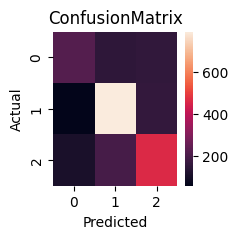

In [30]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(2,2))
sns.heatmap(cm)
plt.title("ConfusionMatrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [32]:
lenet_model.save("lenet_model.h5")